# NSSP Projet 2

## PART 1 : Single subject classification

### Import

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle

### Load subject 2

In [30]:
data = loadmat("s2/S2_A1_E1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


### 1 Visualize and preprocess the data

In [31]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

stimulus = data["restimulus"] 
repetition = data["rerepetition"] 

print("Stimuli {} , Repetitions {}".format(stimulus.shape,repetition.shape))

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg.shape[1]

print(f'Number of movements : {n_stimuli}') 
print(f'Number of repetitions : {n_repetitions}') 

EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>
Stimuli (100686, 1) , Repetitions (100686, 1)
Number of movements : 12
Number of repetitions : 10


In [32]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Number of sample per trials \n Mean : {} \n std : {} \n min : {} \n max: {}".format(number_of_samples_per_trial.mean(),number_of_samples_per_trial.std(),number_of_samples_per_trial.min(),number_of_samples_per_trial.max()))

Number of sample per trials 
 Mean : 348.2583333333333 
 std : 66.62450698170723 
 min : 196.0 
 max: 516.0


#### Visualize first channel

Text(0, 0.5, 'Amplitude')

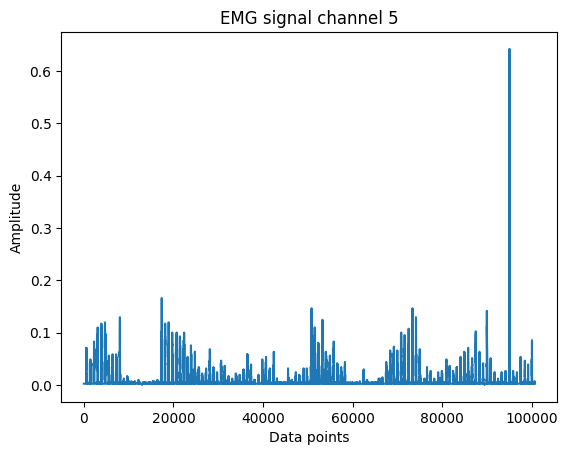

In [33]:
# Plot first channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()
EMG_channel = 5
ax.plot(emg[:, EMG_channel])   
ax.set_title(f"EMG signal channel {EMG_channel}")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

#### Visualize all channels 

In [34]:
# Defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], 
                                                                mov_mean_weights, axis=0)

Text(0.5, 0.98, 'Envelopes of the EMG signal')

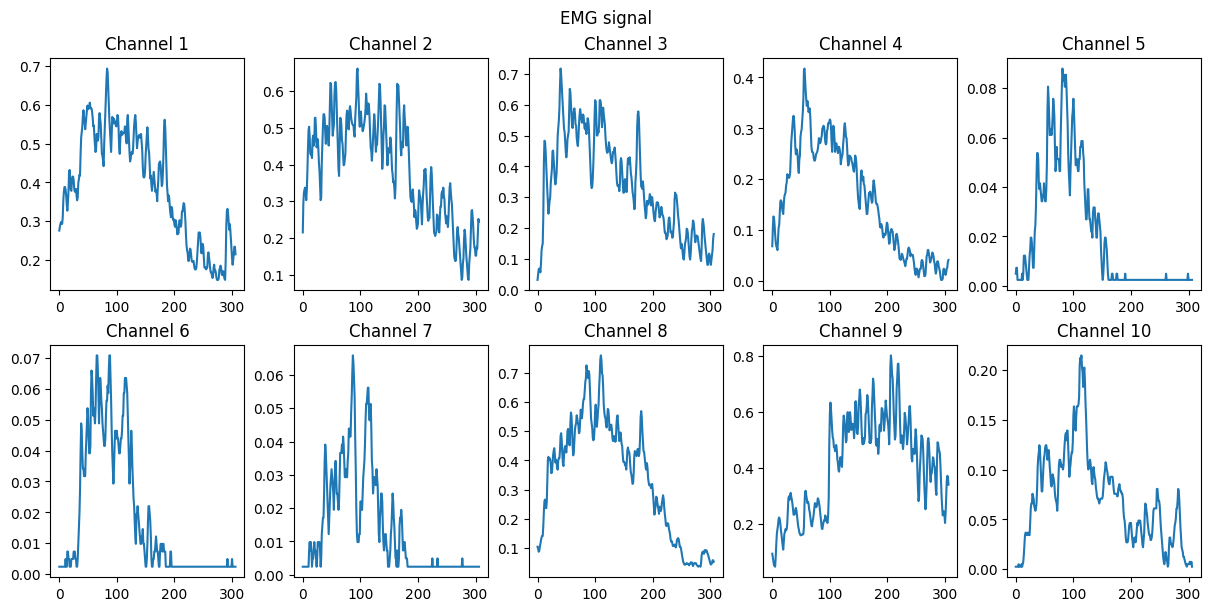

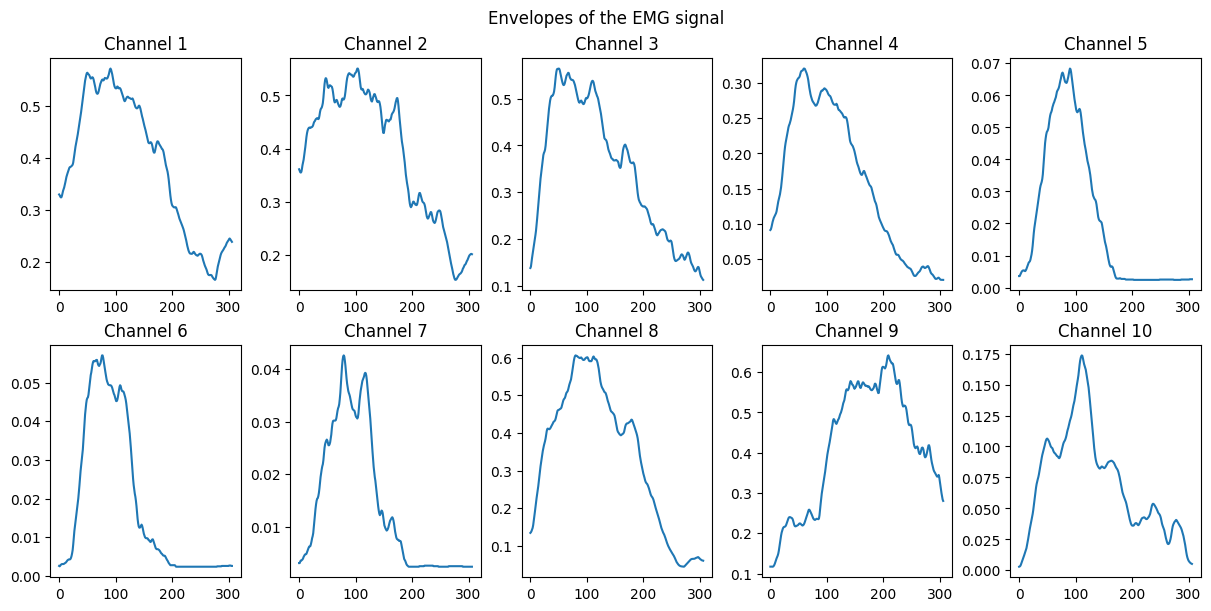

In [35]:
# Plot EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

# 10 EMG channels
number_of_emg_channels = emg.shape[-1]

for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")

plt.suptitle("EMG signal")

# Plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")

plt.suptitle("Envelopes of the EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

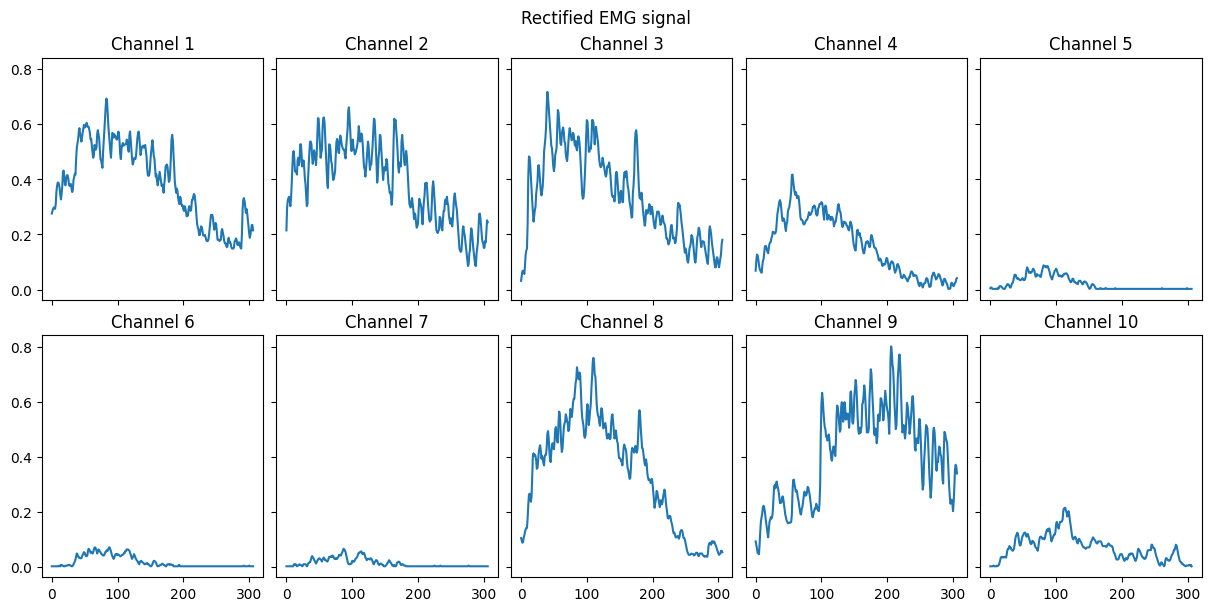

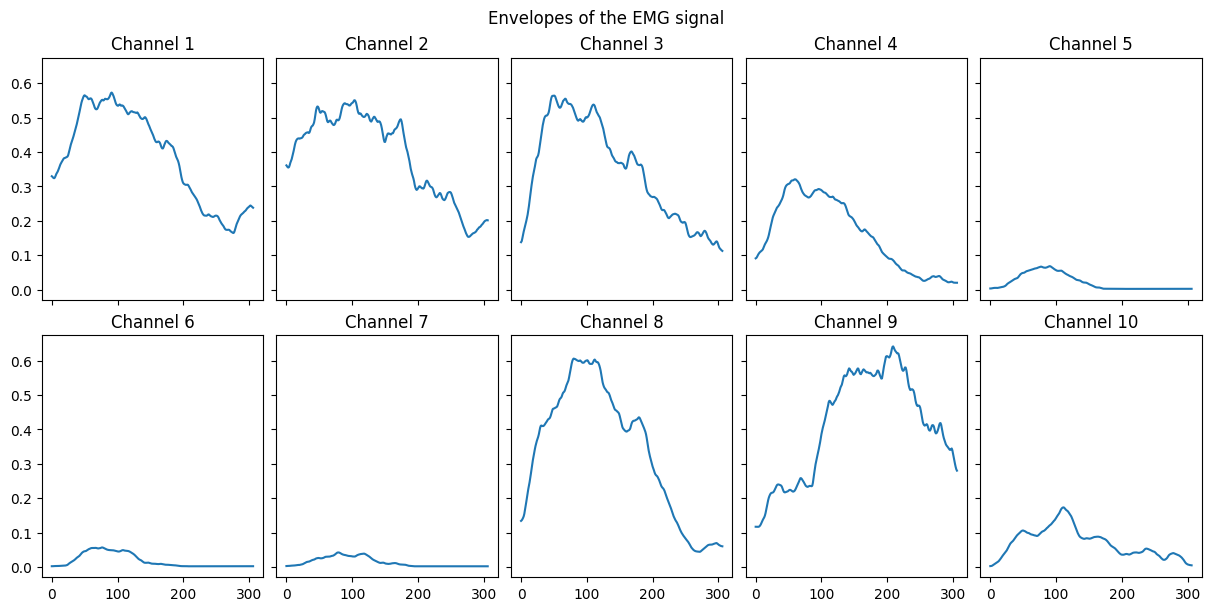

In [36]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

In [37]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

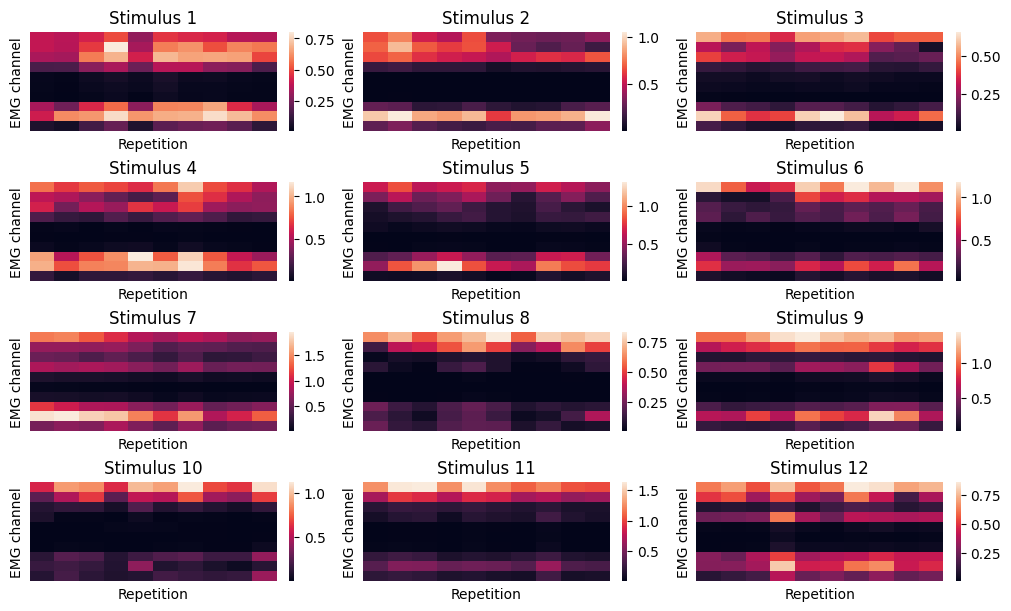

In [38]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

#### Preprocessing 

In [39]:
#1st order Butterworth low-pass filter with 1Hz cutoff frequency
fs = 2000
cutoff_frequency = 1
sos = butter(N=4, Wn=cutoff_frequency, fs=fs, btype="lowpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

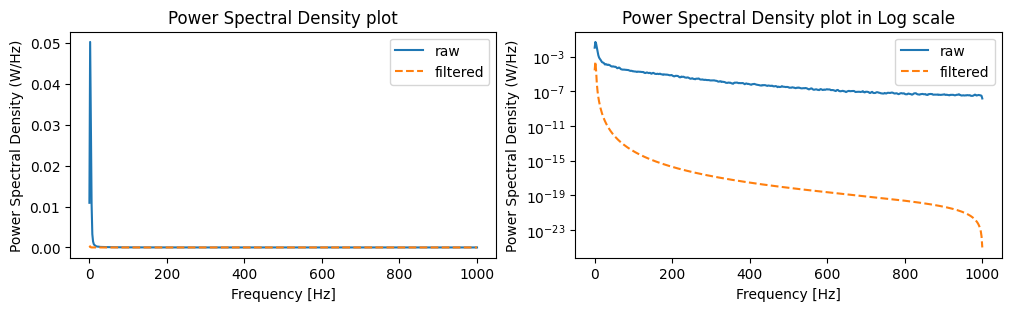

In [40]:
#check how power density changed after filtering 
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

### 2 Split the data into train/test/validation sets

In [41]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

#### Extracting the features

In [42]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[2:] - x[1:-1])) < 0,
    axis=0
)

# Using the dataset function with the implemented features
dataset, labels = build_dataset_from_ninapro(
    emg=emg_filtered,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc]  # Include all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 60)
labels dimension: (120,)


In [43]:
features=["mav", "std", "maxav", "rms", "wl", "ssc"]
nb_features = len(features)
col = [f"channel {i}" for i in range(1, n_channels+1)]

DataMean = pd.DataFrame(dataset.mean(axis = 0).reshape(nb_features,n_channels),columns=col, index=features)
DataMean

channel 1  channel 2  channel 3  channel 4  channel 5  channel 6  \
mav     0.398976   0.327178   0.158436   0.109447   0.015494   0.006042   
std     0.011702   0.014816   0.004799   0.004425   0.000732   0.000248   
maxav   0.418352   0.352017   0.166475   0.116773   0.016715   0.006460   
rms     0.399248   0.327755   0.158578   0.109640   0.015535   0.006053   
wl      0.040545   0.051325   0.016540   0.015360   0.002537   0.000866   
ssc     0.258333   0.250000   0.208333   0.275000   0.258333   0.266667   

       channel 7  channel 8  channel 9  channel 10  
mav     0.011292   0.156627   0.335237    0.083238  
std     0.000599   0.006024   0.011763    0.003598  
maxav   0.012299   0.166617   0.354864    0.089244  
rms     0.011326   0.156847   0.335677    0.083405  
wl      0.002101   0.020851   0.040756    0.012421  
ssc     0.308333   0.208333   0.233333    0.225000

Text(0.5, 0.98, 'Mean on each chanel')

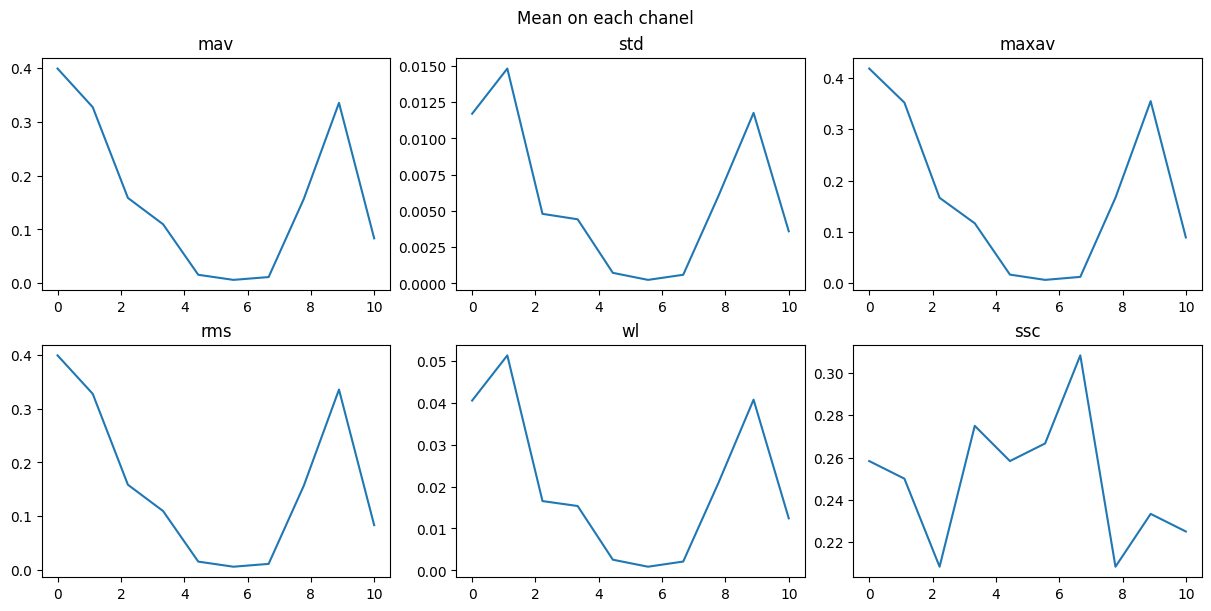

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

# plot Rectified EMG signal
for feature in range(nb_features): 
    ax[feature].plot(np.linspace(0,n_channels,n_channels),DataMean.iloc[feature])
    ax[feature].set_title(features[feature])
plt.suptitle("Mean on each chanel")

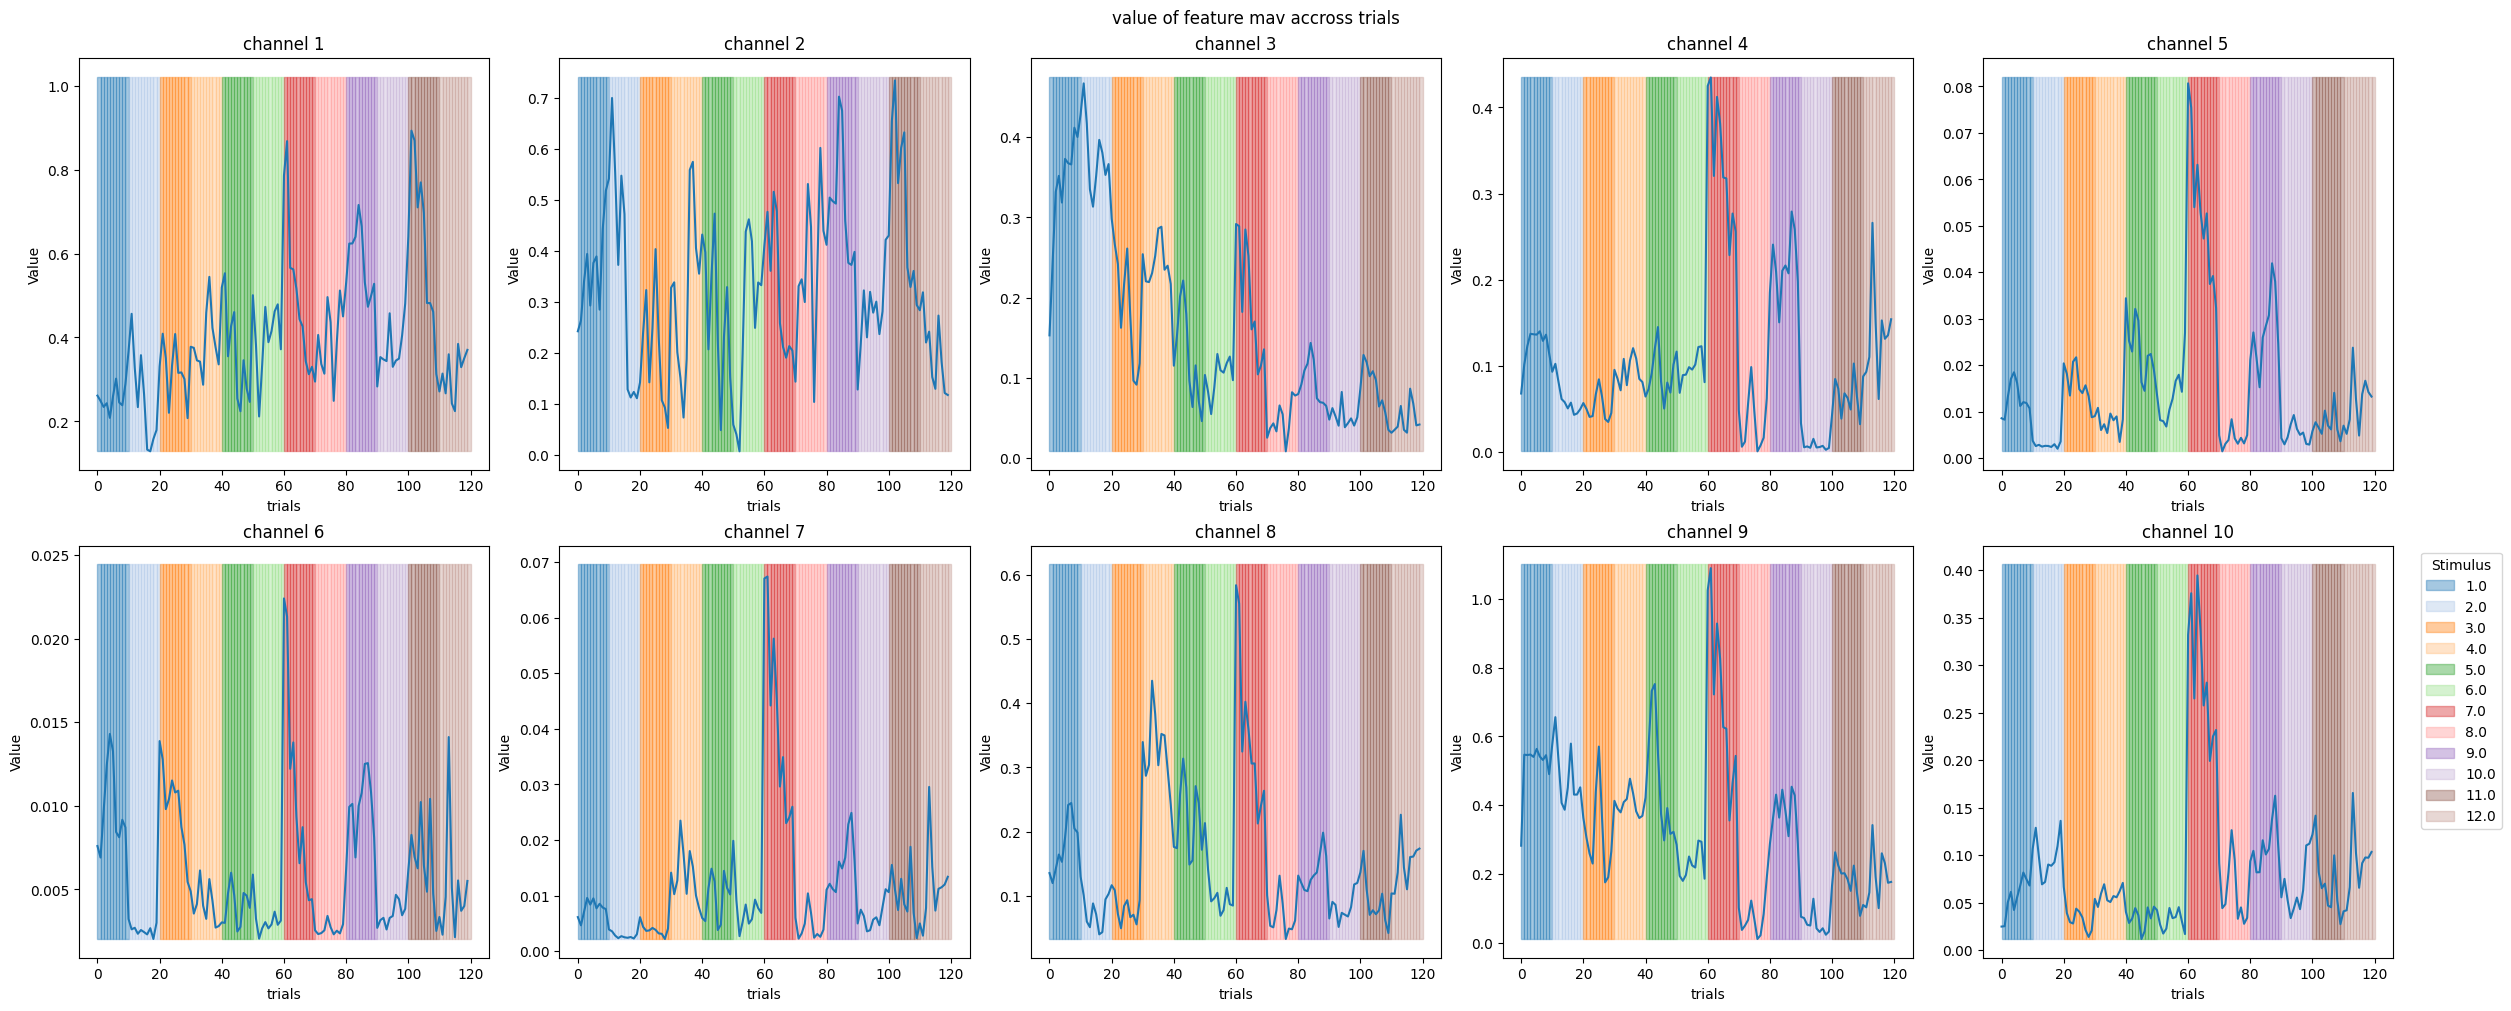

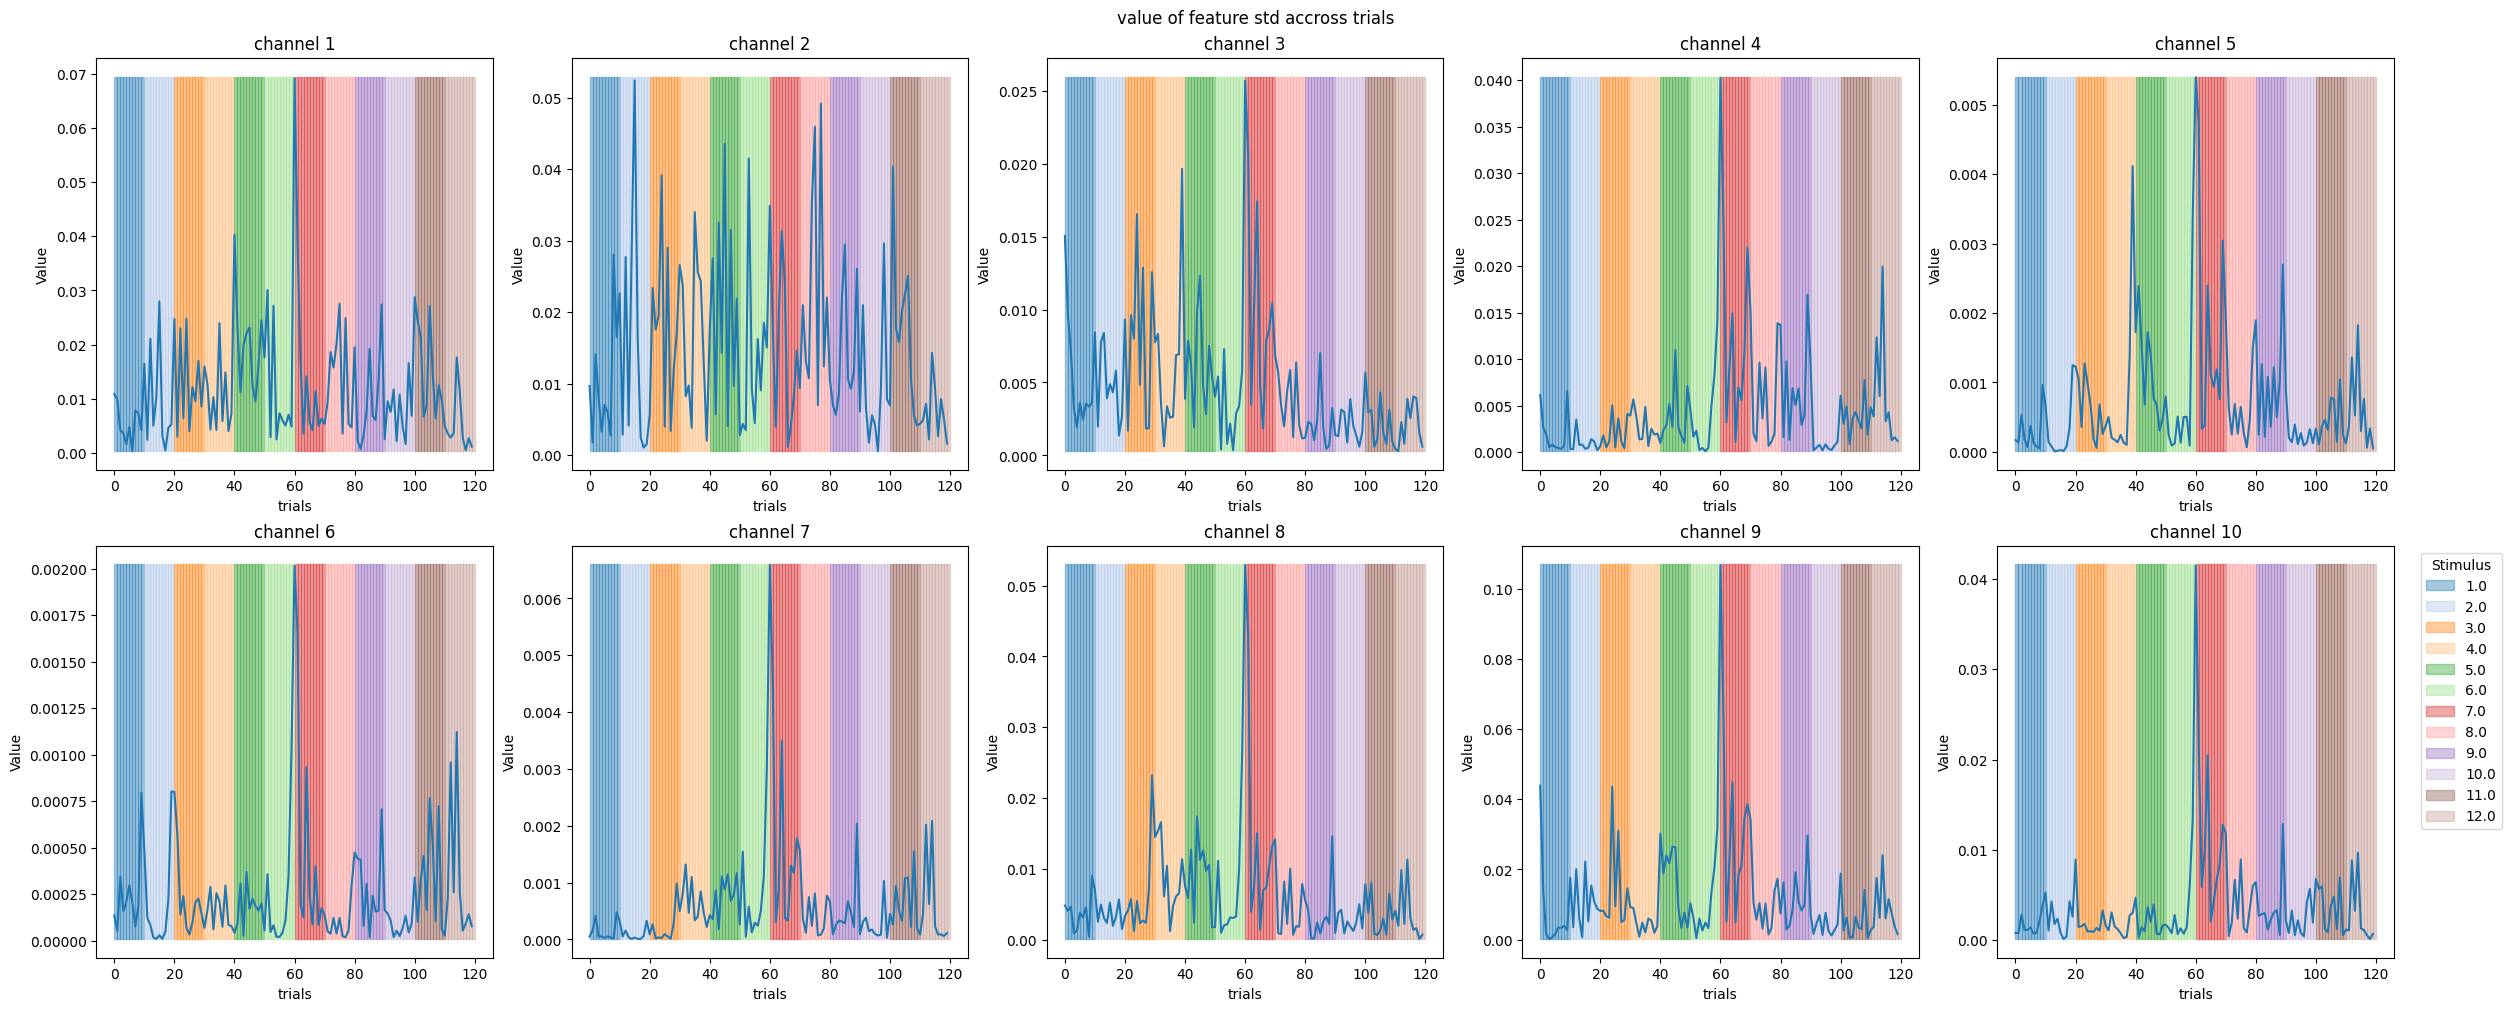

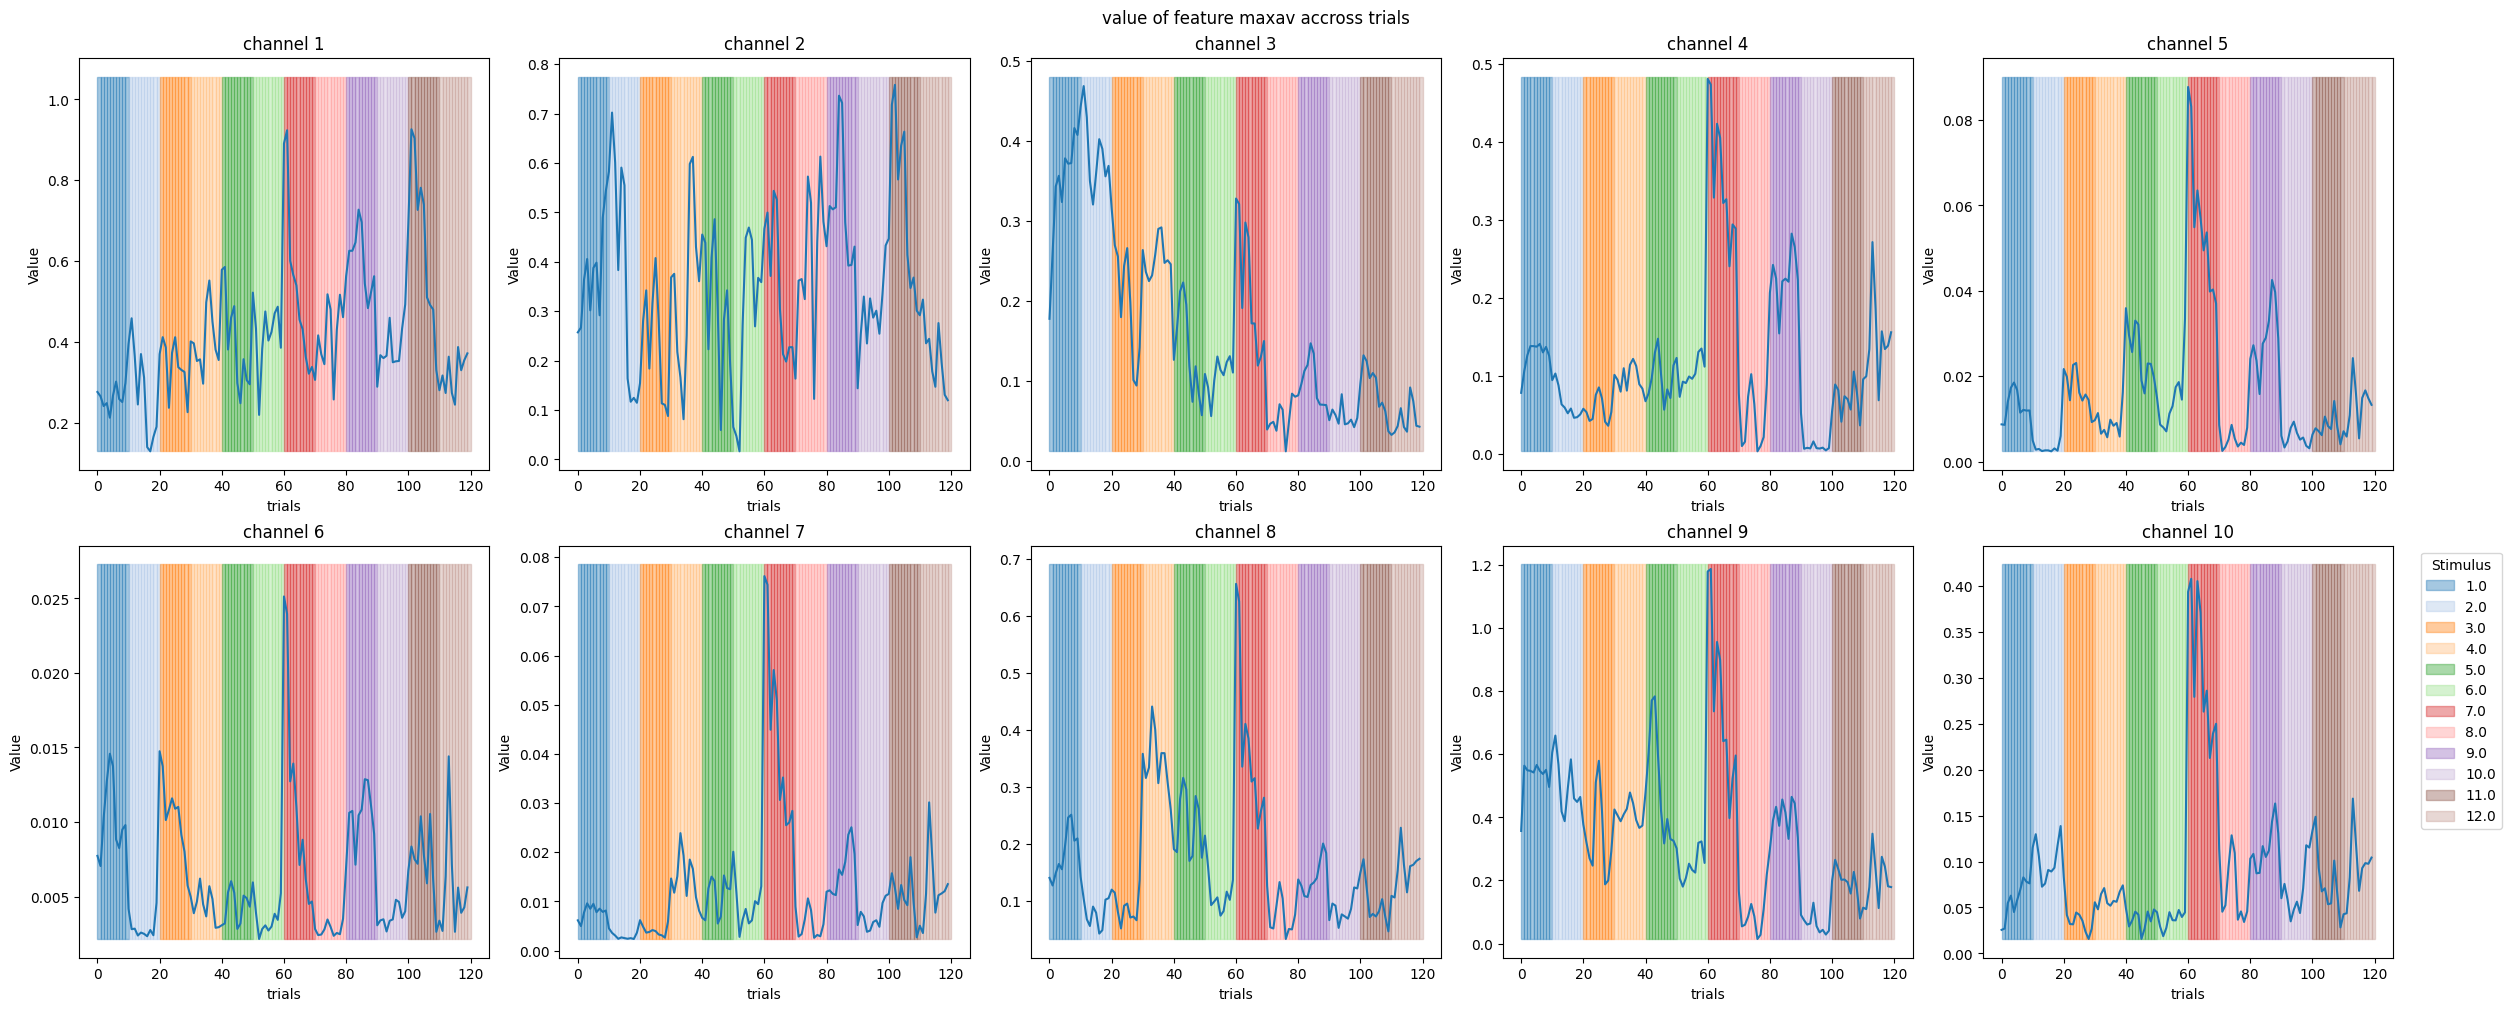

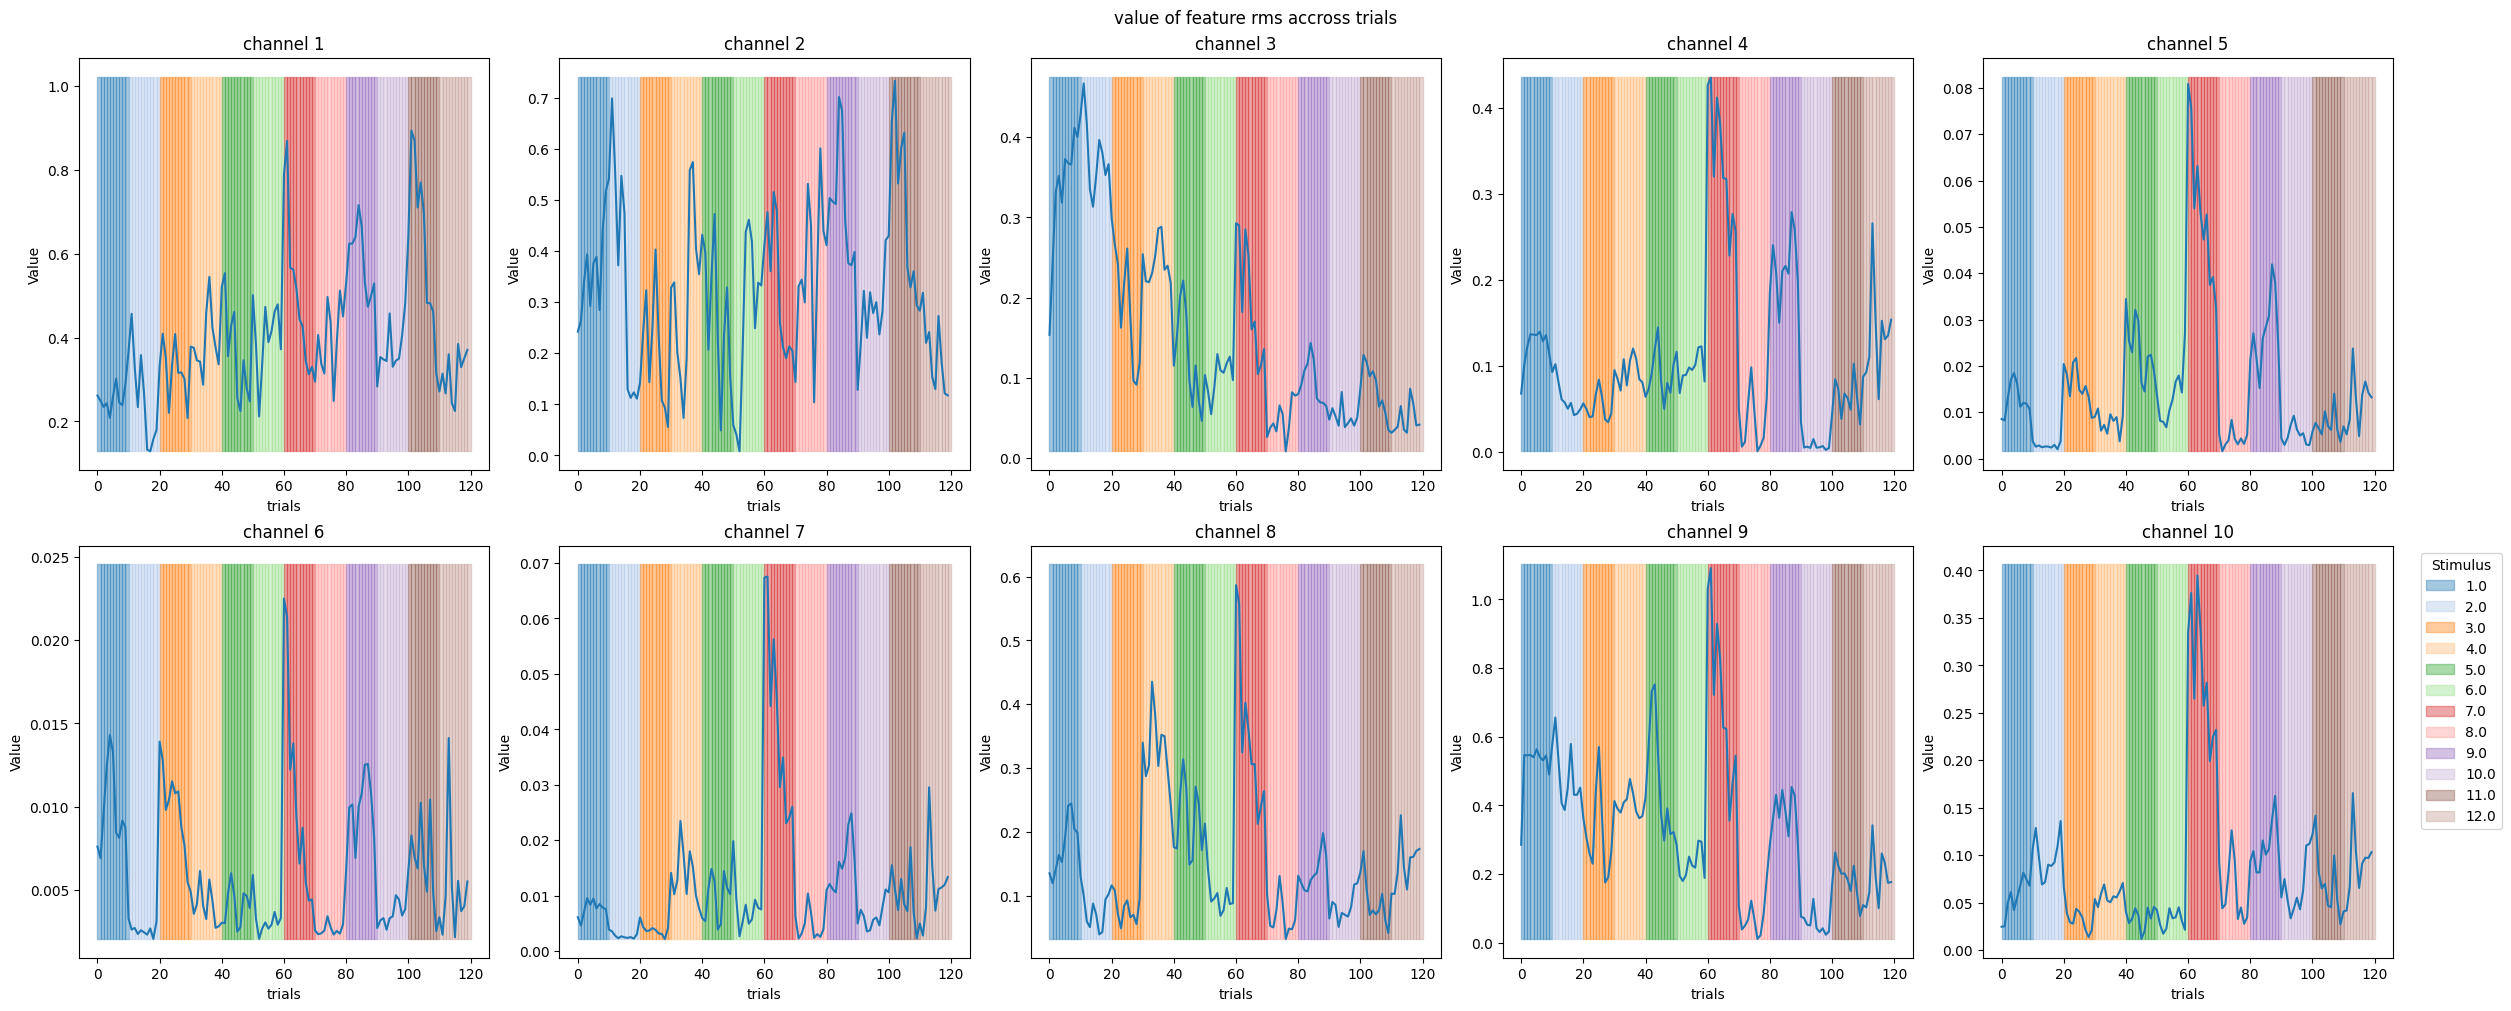

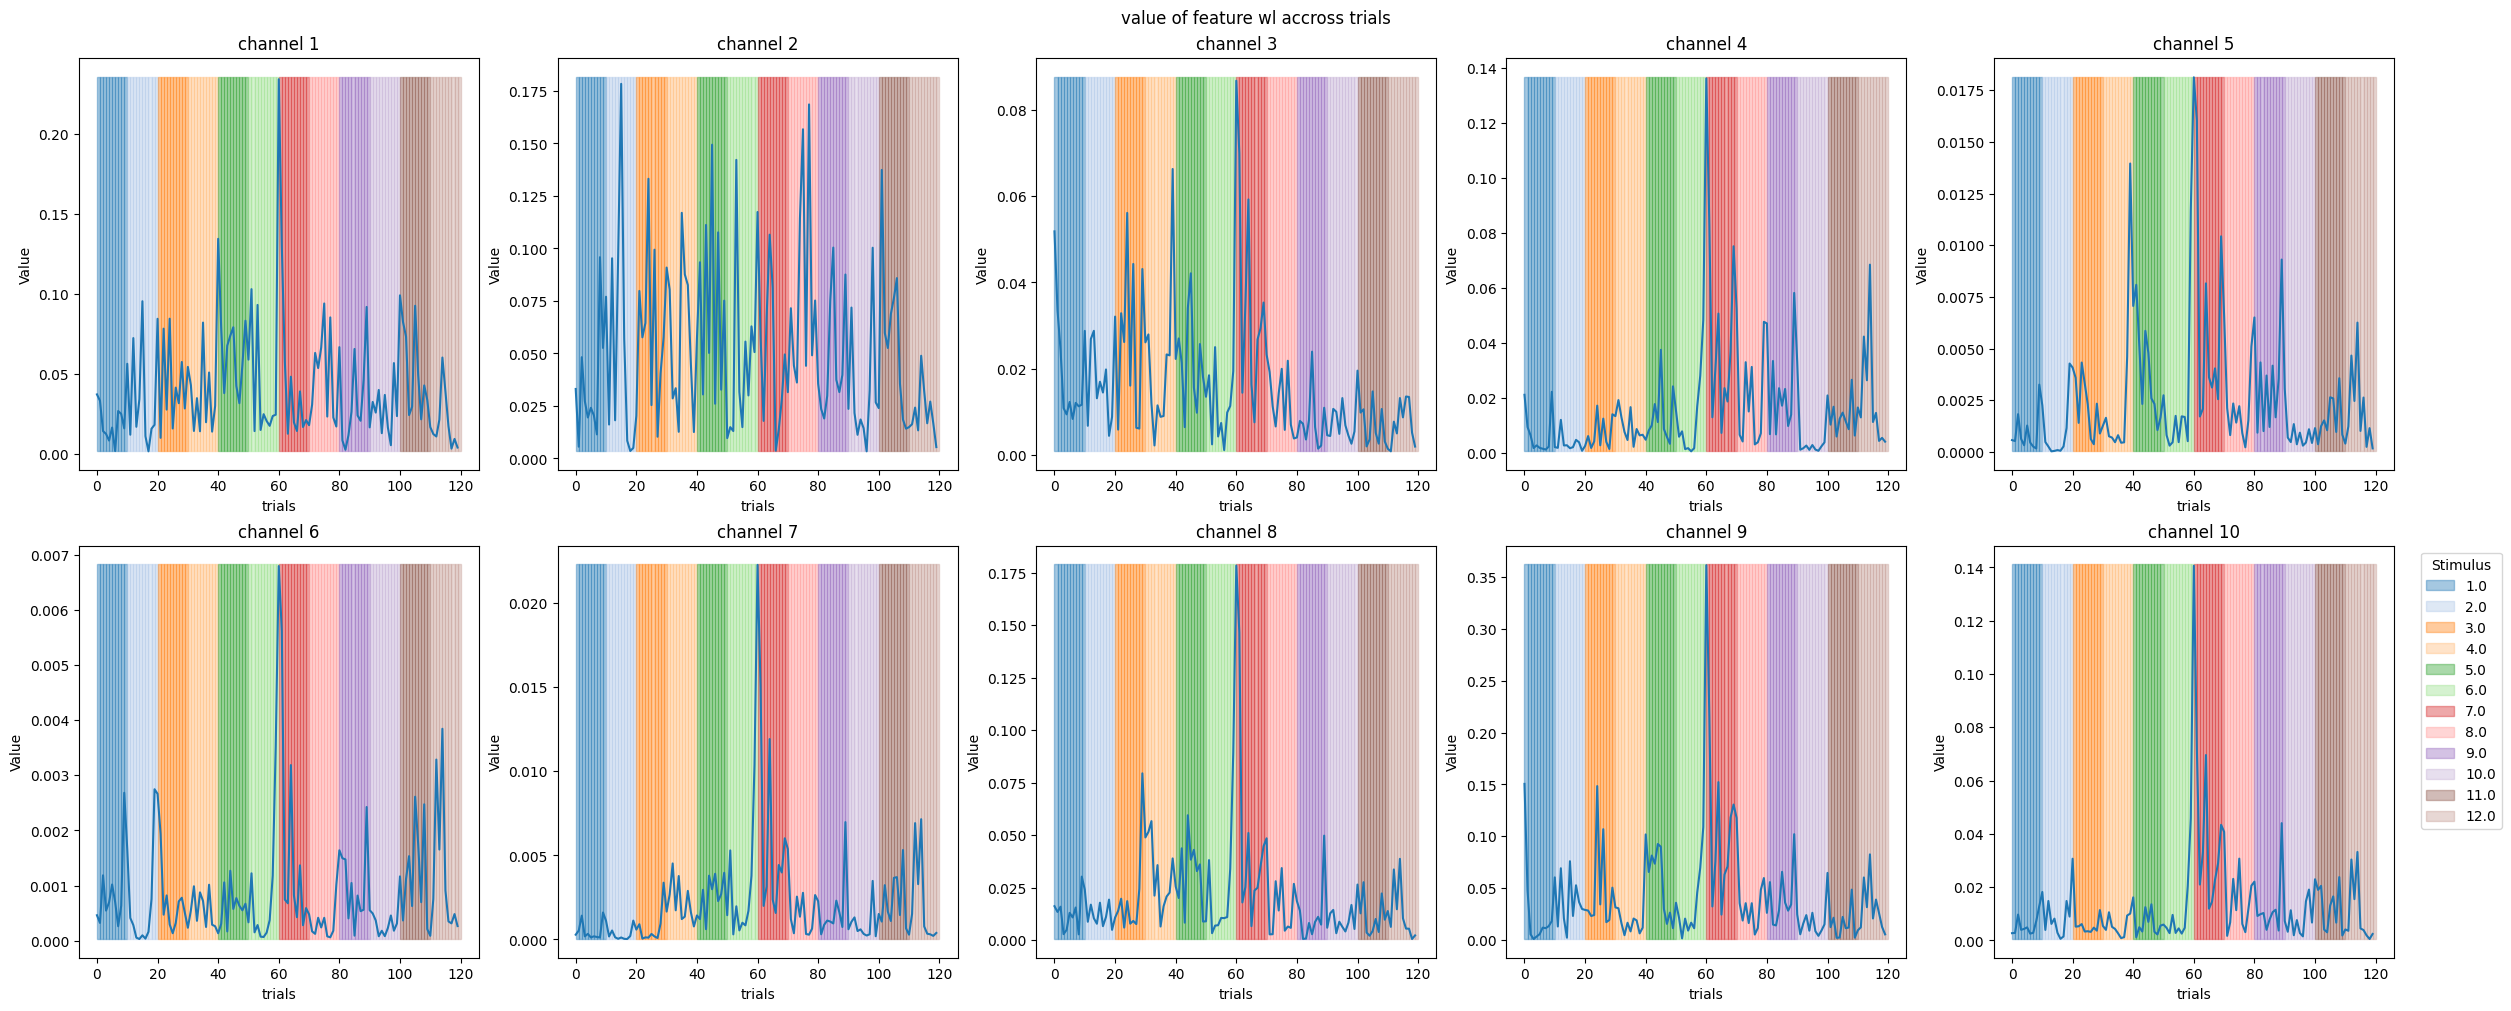

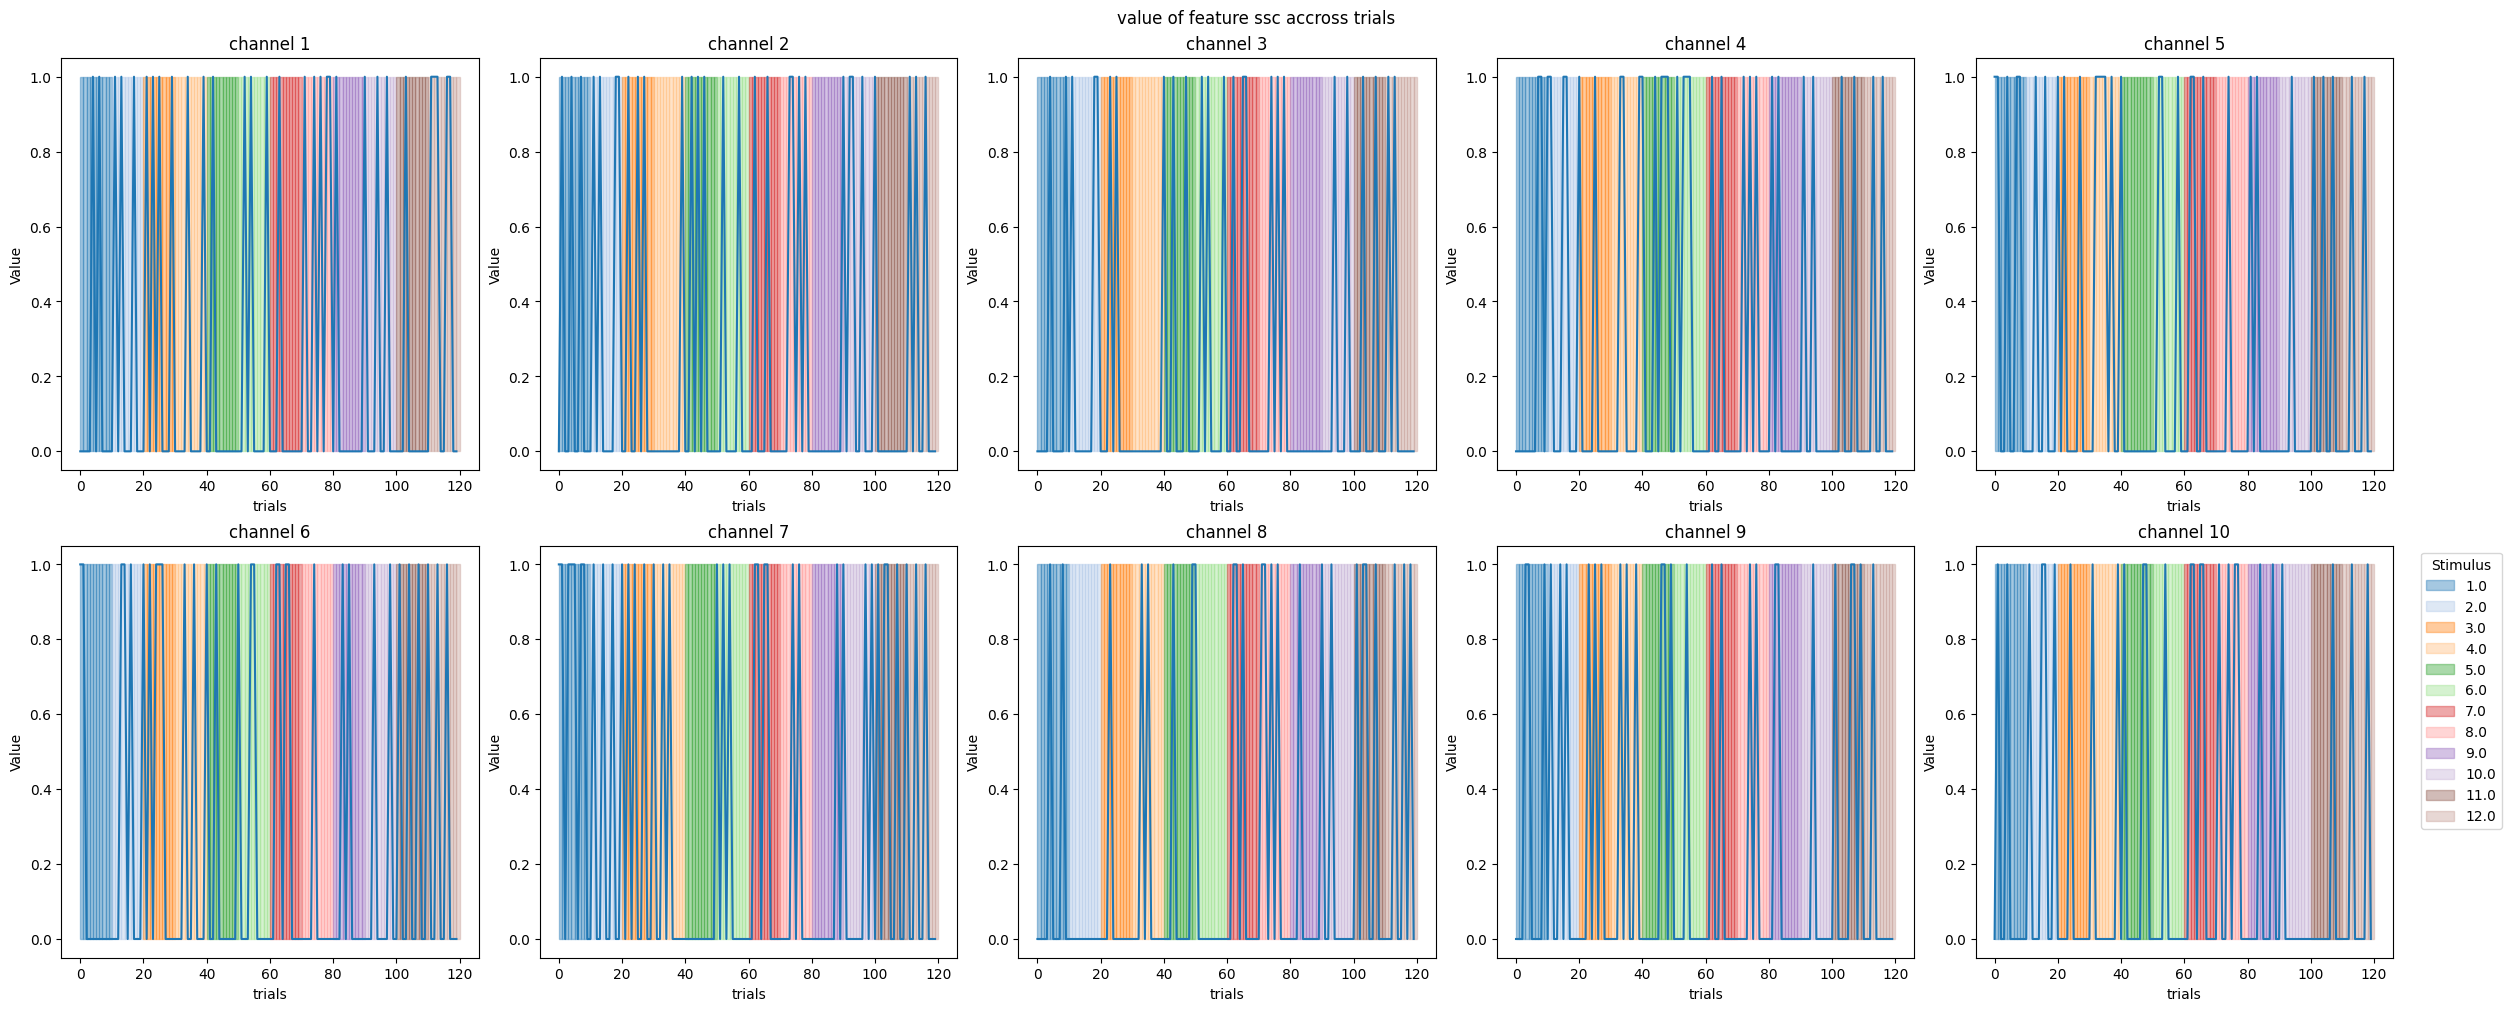

In [45]:
colors = sns.color_palette("tab20", n_colors=12) 

for feature_nb,feature in enumerate(features) : 
    fig, ax = plt.subplots(2, 5, figsize=(25, 10), constrained_layout=True)
    ax = ax.ravel()
    
    for channel in range(n_channels):
        # Draw stimulus
        dataplot = dataset[:,channel+(feature_nb*n_channels)]
        for i, label in enumerate(labels):
            rect = Rectangle((i, min(dataplot)), 1, max(dataplot), color=colors[int(label - 1)], alpha=0.4)  # Background rectangle
            ax[channel].add_patch(rect)
        #add feature
        ax[channel].plot(dataplot)
        ax[channel].set_xlabel("trials")
        ax[channel].set_ylabel("Value")
        ax[channel].set_title("channel {}".format(channel+1))
    
    handles = [Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.4) for i in range(12)]  # Create legend patches
    plt.legend(handles, np.linspace(1,n_stimuli,n_stimuli), title="Stimulus", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle("value of feature {} accross trials".format(feature))
    plt.show()

#### Splitting the data

In [46]:
# Split the dataset into training and testing sets
# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3)

# Normalizing the data with a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  
X_test_z = scaler.transform(X_test)   

print("Train shape {}".format(X_train_z.shape))
print("Test shape {}".format(X_test_z.shape))

Train shape (84, 60)
Test shape (36, 60)


### 4 Classification using Random Forest

#### Hyperparameters optimization : method 1

In [47]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 10, 20, 30, 40],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider for the best split
    'bootstrap': [True, False]                 # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=5,       # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1   # Use all available cores
)

# Fit the model to the training data
random_search.fit(X_train_z, y_train)

# Get the best parameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total

In [54]:
y_pred1 = best_model.predict(X_test_z)
print("Predicted actions:", y_pred1)

Predicted actions: [ 6.  4.  9. 11.  1.  9.  9.  3.  6.  7.  7.  4. 10. 11.  8.  5. 10.  2.
 10.  3. 11.  2.  9.  1. 11.  9.  1. 10. 12.  7.  1.  2.  5.  5. 12. 12.]


#### Hyperparameters optimization : method 2

In [55]:
param_grid = {
    "n_estimators": [10,50,100,500], #range(10, 100, 10),
    "bootstrap": [True, False],
    "criterion": ['gini', 'absolute_error', 'poisson', "log_loss"],
    "max_features" : ["sqrt", "log2", 1, 5, 10, None], 
    "max_depth": [None, 10, 20, 30, 40],
    "max_leaf_nodes": range(3,15,5),
}

grid = GridSearchCV(RandomForestClassifier(), param_grid)
grid.fit(X_train_z,y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

KeyboardInterrupt: 

### 5 Evaluate the performance

#### Method 1

Optimized Accuracy Score: 0.8055555555555556


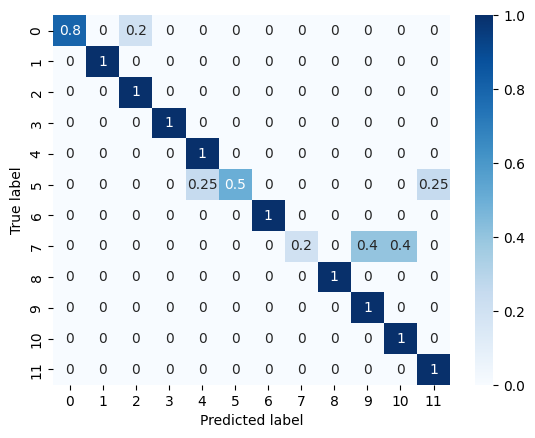

In [53]:
# Evaluate the best model on the test set
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Optimized Accuracy Score: {accuracy1}")

# Create and plot a confusion matrix
confmat1 = confusion_matrix(y_test, y_pred1, normalize='true')
fig, ax = plt.subplots()
sns.heatmap(confmat1, annot=True, ax=ax, cmap="Blues")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

### 6 Features selection / Dimension reduction

#### Method 1 : Mutual information for feature selection

Estimated mutual information between each feature and the target:
 [0.51132921 0.13019941 0.9594676  1.01044202 0.87601891 0.68708071
 0.62072622 0.56498936 1.08067601 0.57220284 0.0865175  0.
 0.22052053 0.23227964 0.26769308 0.09296448 0.36668103 0.24539247
 0.21285112 0.20551521 0.53942273 0.16227803 1.0107136  0.94146077
 0.82164066 0.66607536 0.59698023 0.60304151 1.09322544 0.56577729
 0.51520301 0.12975072 0.95565896 0.99466367 0.86436646 0.69593321
 0.58301332 0.57879429 1.08718909 0.5650989  0.05544591 0.
 0.18338523 0.25992058 0.24401673 0.10592524 0.40913752 0.26721589
 0.21231386 0.19349925 1.05656005 0.79677974 1.0814394  0.4179226
 1.00217978 0.89473343 0.69439278 1.04501775 1.18728223 0.45423409]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, mi

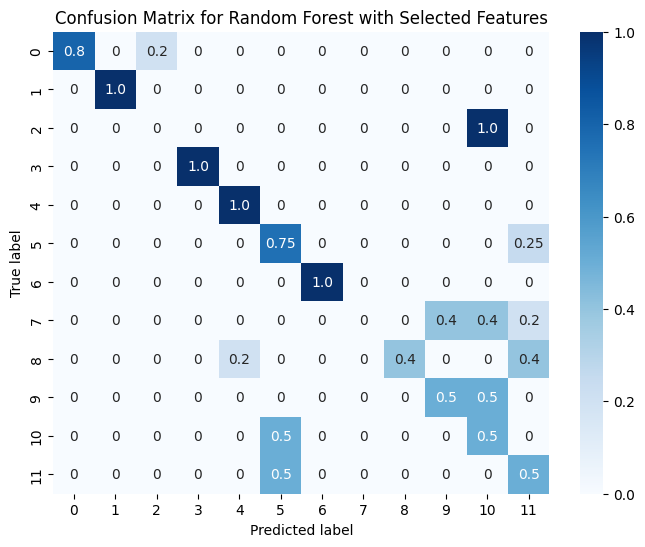

In [56]:
# Step 1: Calculate mutual information
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Step 2: Select top 'k' features based on mutual information scores
k = 10  # number of top features to select
k_best = SelectKBest(score_func=mutual_info_classif, k=k)
k_best.fit(X_train_z, y_train)

# Step 3: Transform datasets to include only the selected features
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

# Step 4: Train a Random Forest Classifier using the reduced feature set
# Fit the model to the training data
random_search.fit(X_train_best, y_train)
best_model = random_search.best_estimator_

# Step 5: Evaluate the model
y_pred = best_model.predict(X_test_best)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of the Random Forest model with top {k} features: {accuracy}")

# Step 6: Create a confusion matrix for performance visualization
confmat = confusion_matrix(y_test, y_pred, normalize="true")
# Create a mask to hide zero values
mask = confmat == 0

# Plot the confusion matrix with dynamic annotation
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confmat, annot=np.where(mask, "0", confmat.round(2)), fmt="", cmap="Blues", cbar=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix for Random Forest with Selected Features")
plt.show()

In [57]:
print("Predicted actions:", y_pred)

Predicted actions: [ 6.  4. 12.  6.  1. 12.  5.  3.  6.  7.  7.  4. 10. 11. 11.  6. 11.  2.
 10. 11. 11.  2.  9.  1. 12.  9.  1. 10. 12.  7.  1.  2.  5.  5. 12.  6.]


#### Method 2 : PCA for dimension reduction

Shape after PCA - Training: (84, 17), Testing: (36, 17)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_sa

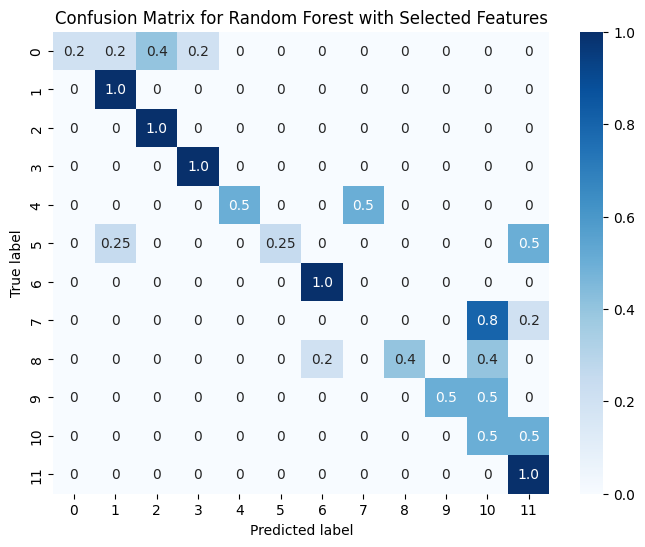

In [58]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_z)
X_test_pca = pca.transform(X_test_z)

print(f"Shape after PCA - Training: {X_train_pca.shape}, Testing: {X_test_pca.shape}")

#Train a Random Forest model on the PCA-transformed data
random_search.fit(X_train_pca, y_train)
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test_pca)

#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of the Random Forest model with PCA features: {accuracy}")

#Create a confusion matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
mask = confmat == 0
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confmat, annot=np.where(mask, "0", confmat.round(2)), fmt="", cmap="Blues", cbar=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix for Random Forest with Selected Features")
plt.show()

In [ ]:
print("Predicted actions:", y_pred)

#### Method 3 : Recursive Feature Elimination with Cross-Validation (RFECV)

Accuracy score of the Random Forest model with PCA features: 0.75


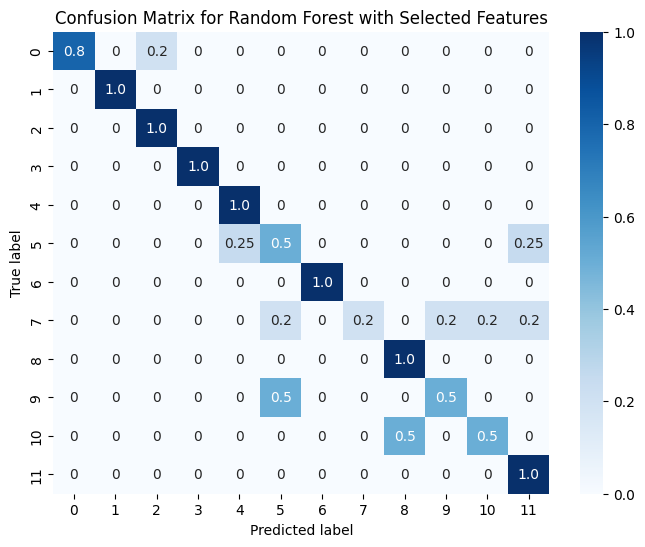

In [60]:
rfecv_model = RFECV(estimator=RandomForestClassifier(random_state=42),
                    step=1,
                    cv=5,
                    scoring='accuracy')
rfecv_model.fit(X_train_z, y_train)

# Transform the train and test sets using selected features
X_train_rfecv = rfecv_model.transform(X_train_z)
X_test_rfecv = rfecv_model.transform(X_test_z)

# Train a RandomForestClassifier on RFECV-selected features
rfecv_final_model = RandomForestClassifier(random_state=42)
rfecv_final_model.fit(X_train_rfecv, y_train)

y_pred = rfecv_final_model.predict(X_test_rfecv)

#Calculate accuracy
rfecv_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of the Random Forest model with PCA features: {rfecv_accuracy}")

#Create a confusion matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
mask = confmat == 0
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confmat, annot=np.where(mask, "0", confmat.round(2)), fmt="", cmap="Blues", cbar=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix for Random Forest with Selected Features")
plt.show()